In [31]:
import os
import pandas as pd

In [32]:





train_dir='expression/images/images/train/'
test_dir='expression/images/images/validation/'

In [33]:
def get_paths(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                image_paths.append(image_path)
                labels.append(label)
    return image_paths, labels



img_train_paths, lbl_train = get_paths(train_dir)
img_test_paths, lbl_test = get_paths(test_dir)

In [34]:
train_df=pd.DataFrame({'path':img_train_paths,'emotion':lbl_train})

test_df=pd.DataFrame({'path':img_test_paths,'emotion':lbl_test})

In [35]:
train_df

,path,emotion
0,expression/images/images/train/angry\0.jpg,angry
1,expression/images/images/train/angry\1.jpg,angry
2,expression/images/images/train/angry\10.jpg,angry
3,expression/images/images/train/angry\10002.jpg,angry
4,expression/images/images/train/angry\10016.jpg,angry
...,...,...
28816,expression/images/images/train/surprise\9969.jpg,surprise
28817,expression/images/images/train/surprise\9985.jpg,surprise
28818,expression/images/images/train/surprise\9990.jpg,surprise
28819,expression/images/images/train/surprise\9992.jpg,surprise


In [36]:
test_df

,path,emotion
0,expression/images/images/validation/angry\1005...,angry
1,expression/images/images/validation/angry\1006...,angry
2,expression/images/images/validation/angry\1007...,angry
3,expression/images/images/validation/angry\1009...,angry
4,expression/images/images/validation/angry\1012...,angry
...,...,...
7061,expression/images/images/validation/surprise\9...,surprise
7062,expression/images/images/validation/surprise\9...,surprise
7063,expression/images/images/validation/surprise\9...,surprise
7064,expression/images/images/validation/surprise\9...,surprise


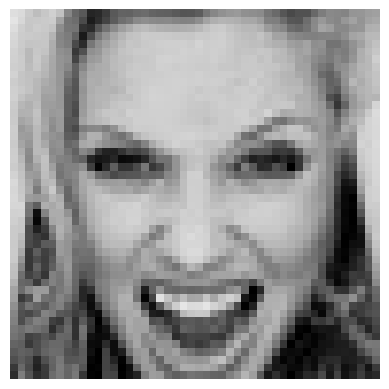

In [37]:
import cv2
import matplotlib.pyplot as plt

# Resmi oku
photo_resize = cv2.imread(train_df['path'][4])

# Resmi göster
plt.imshow(cv2.cvtColor(photo_resize, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [38]:
img=cv2.imread(train_df.path[4])
img.shape

(48, 48, 3)

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img
import numpy as np



In [40]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=train_df,
    x_col="path",  # Görüntü dosyalarının yolu
    y_col="emotion",  # Etiket sütunu
    target_size=(48,48),
    batch_size=128,
    class_mode='categorical',
    shuffle=True  # Veri yükleme işlemini karıştırmadan yaparız
)


test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col="path",        # Görüntü dosyalarının yolu
    y_col="emotion",     # Etiket sütunu
    target_size=(48,48),
    batch_size=128,
    class_mode='categorical',
    shuffle=True        # Test verilerini karıştırmadan yükleme yaparız (shuffle=False)
)



Found 28821 validated image filenames belonging to 7 classes.
Found 7066 validated image filenames belonging to 7 classes.


In [38]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [39]:
test_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
train_data_size = len(train_generator.classes)
test_data_size = len(test_generator.classes)


model = Sequential()



model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48,48,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))



model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

# Model derleme
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model eğitimi
early_stopping = EarlyStopping(monitor='val_loss', mode='min' ,patience=5)
model_checkpoint = ModelCheckpoint('emotion_model.h5', mode='min',monitor='val_loss', save_best_only=True)

# Model eğitimi
history = model.fit(
    train_generator,
    steps_per_epoch=train_data_size // 128,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_data_size // 128,
    callbacks=[early_stopping, model_checkpoint]
      # Geriçağırıcıları belirtin
)

In [20]:
from tensorflow.keras.models import load_model

In [21]:

model = load_model('emotion_model.h5') # eğitilmiş veriler yüklenir...

In [22]:

emotions = ['Kizgin', 'Tiksinme', 'Korku', 'Mutlu', 'Dogal', 'Uzgun', 'Saskin']




face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    
    ret, frame = cap.read()

  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    
    for (x, y, w, h) in faces:
        face_roi = gray[y:y + h, x:x + w]

        
        face_rgb = cv2.cvtColor(face_roi, cv2.COLOR_GRAY2RGB)

        
        resized_image = cv2.resize(face_rgb, (48, 48))

       
        resized_image = resized_image.astype('float32') / 255.0

       
        prediction = model.predict(np.expand_dims(resized_image, axis=0))
        max_index = np.argmax(prediction)
        emotion = emotions[max_index]

      
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

       
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_TRIPLEX, 0.9, (255, 0, 0), 2)

  
    cv2.imshow('Webcam', frame)

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 22ms/step


In [41]:
test_loss, test_accuracy = model.evaluate(test_generator)


print("Modelin Doğruluğu:", test_accuracy)




56/56 [==============================] - 52s 936ms/step - loss: 1.2203 - accuracy: 0.5592
Modelin Doğruluğu: 0.5591565370559692
